In [166]:
# oimization ideas:
# 	* find the furthest red pixels up down left right and do the rolling window only there to find if there is a sign
# 	* don't check for every single pixel in shape, rather choose a relevant number of pixels to check and only check that many (
# 		- eg: check every other pixel for a 200 by 200 pixel sign
#       - do a maximum of 1% culling and show at max one at every 10 px on OX and one in every 10 on OY. Balance the values to be 3:2 instead of 6:1


# current best strategy:   
#   * find all red chunks in immage
#   * think of every chunk as a give way sign with:
#       - side starting in the top left highest red pixel and ending in the top right red pixel
#       - and height startign in the lowest red piexel and ending in the perpendicular highest red pixel above
#   * account for rotation and for squishing in the immage
#   * try to get width of the red triangle in pixels and adjust in the funciton

# optimisations:
#   * check only a percentage of pixels
#   * when looking for a chunk stop if found and then not found

In [167]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from dataclasses import dataclass

In [243]:
DATA_DIR = "./my-dataset"
GIVE_WAY_DIR = os.path.join(DATA_DIR, "give-way/single_sign_neighborhood_set/the_dataset")
GIVE_WAY_SOLVED_DIR = os.path.join(DATA_DIR, "give-way/single_sign_neighborhood_set/solved_dataset")

RED_PX = 0
GREEN_PX = 1
BLUE_PX = 2

APPROXIMATE_PIXELS_TO_CHECK = 1000
SMALL_GW_BORDER_PER_CENT = 0.7

In [169]:
# useful structs

@dataclass
class point:
    x: float
    y: float

@dataclass 
class give_way_chunk:
    top_left_point:  point
    top_right_point: point 
    bottom_point:    point

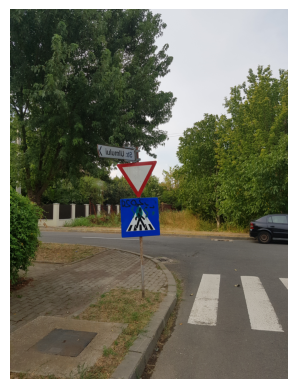

In [170]:
# print a picture

gw_images = []
for img_name in sorted(os.listdir(GIVE_WAY_DIR)):
    gw_images.append(np.transpose(mpimg.imread(os.path.join(GIVE_WAY_DIR, img_name)), (1, 0, 2)))
    
test_img = gw_images[7]

plt.imshow(test_img)
plt.axis('off')
plt.show()

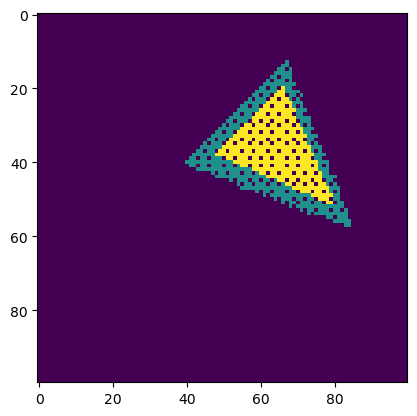

In [190]:
# draw a black and white give way sign of arbitrary size, only draw a portion of the pixels

def between(p_val, p_lower, p_higher):
    return p_val <= p_higher and p_val >= p_lower

def point_area(p_point1, p_point2, p_point3):
    return np.abs(p_point1.x*(p_point2.y-p_point3.y) + p_point2.x*(p_point3.y-p_point1.y) + p_point3.x*(p_point1.y-p_point2.y)) / 2.0

def area(p_x1, p_y1, p_x2, p_y2, p_x3, p_y3):
    return np.abs(p_x1*(p_y2-p_y3) + p_x2*(p_y3-p_y1) + p_x3*(p_y1-p_y2)) / 2.0

def in_triangle(p_x, p_y, p_x1, p_y1, p_x2, p_y2, p_x3, p_y3):
    margin_of_error = 0.001

    A = area(p_x1, p_y1, p_x2, p_y2, p_x3, p_y3)

    A1 = area(p_x, p_y, p_x2, p_y2, p_x3, p_y3)
    A2 = area(p_x1, p_y1, p_x, p_y, p_x3, p_y3)
    A3 = area(p_x1, p_y1, p_x2, p_y2, p_x, p_y)

    area_sum = A1 + A2 + A3

    return (A <= area_sum + margin_of_error * area_sum) and (A >= area_sum - margin_of_error * area_sum)

# gets what side the point is on in relation to a line
def get_side(p_point, p_vertex_p1, p_vertex_p2):
    return (p_point.x - p_vertex_p2.x) * (p_vertex_p1.y - p_vertex_p2.y) - (p_vertex_p1.x - p_vertex_p2.x) * (p_point.y - p_vertex_p2.y)

def point_in_triangle(p_point, p_point_tr_1, p_point_tr_2, p_point_tr_3):

    d1 = get_side(p_point, p_point_tr_1, p_point_tr_2)
    d2 = get_side(p_point, p_point_tr_2, p_point_tr_3)
    d3 = get_side(p_point, p_point_tr_3, p_point_tr_1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not(has_neg and has_pos)

def drawSign(p_mat, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
    p_angle = p_angle * np.pi/180
    height_factor = 1

    equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
    if p_height != -1:
        height_factor = p_height / equilateral_height
    else:
        p_height = equilateral_height

    red_tiangle_height = int(equilateral_height * height_factor) 
    converging_factor = 2 / np.sqrt(3) / height_factor # math :)

    shape_area = red_tiangle_height * p_side / 2
    pixels_to_check = 1 * shape_area

    px_culling_rate = 1

    if shape_area > pixels_to_check:
        px_culling_rate =  pixels_to_check / shape_area 
    
    red_band_width = 0.1 * p_side

    for i in range(p_y_start, p_y_start + red_tiangle_height):
        for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
            x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
            y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

            if(np.random.rand() <= px_culling_rate):

                left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
                right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
                bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

                left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
                                    
                right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

                bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

                if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
                    p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)] = 20
                else:
                    p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)] = 10


# matrix = np.zeros((20, 20))
# drawSign(matrix, 1, 6, 10)
# plt.imshow(matrix)

matrix = np.zeros((100, 100))
drawSign(matrix, 40, 40, 40, 45, -45)
plt.imshow(matrix)

# matrix = np.zeros((1000, 1000))
# drawSign(matrix, 300, 200, 500)
# plt.imshow(matrix)

rect area:  1554
percentage to remain: 64.35006435006436
printed 0.25675675675675674


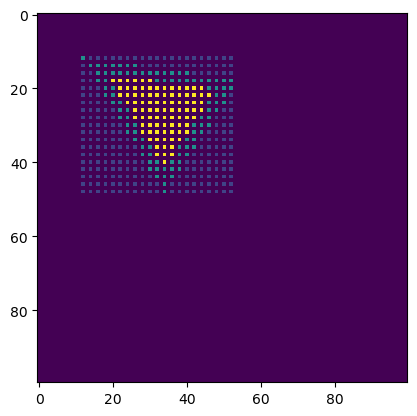

In [211]:
def scale_point_towards_centroid(p_point, p_centroid, p_scale_factor):
    return point(
        p_centroid.x + p_scale_factor * (p_point.x - p_centroid.x), 
        p_centroid.y + p_scale_factor * (p_point.y - p_centroid.y)
    )


def generate_culling_rates(n, m, percentage):
    total_elements = n * m
    target_prints = round(percentage * total_elements)

    # Find the closest factors of target_prints that are less than or equal to n and m
    culling_rate_i = max(round(n / np.sqrt(target_prints)), 1)
    culling_rate_j = max(round(m / np.sqrt(target_prints)), 1)

    return culling_rate_i, culling_rate_j


def draw_scaled_sign_from_points(p_mat, p_left_point, p_right_point, p_bottom_point):
    scale_factor = SMALL_GW_BORDER_PER_CENT
    found_triangle_in_line = False

    view_win_top_left = point(min(p_left_point.x, p_bottom_point.x), min(p_left_point.y, p_right_point.y))
    view_win_btm_right = point(max(p_right_point.x, p_bottom_point.x), p_bottom_point.y)

    px_check_pc = 100
    rectangle_area = (view_win_btm_right.x - view_win_top_left.x) * (view_win_btm_right.y - view_win_top_left.y)
    print("rect area: ", rectangle_area)

    if APPROXIMATE_PIXELS_TO_CHECK < rectangle_area:
        px_check_pc = APPROXIMATE_PIXELS_TO_CHECK / rectangle_area * 100
    print("percentage to remain:", px_check_pc)
    
    rect_height = int(view_win_btm_right.y) - int(view_win_top_left.y)  
    rect_width = int(view_win_btm_right.x) - int(view_win_top_left.x)  
    culling_rate_i, culling_rate_j = generate_culling_rates(rect_height, rect_width, 0.28)

    # Calculate the centroid of the original triangle
    centroid_x = (p_left_point.x + p_right_point.x + p_bottom_point.x) / 3
    centroid_y = (p_left_point.y + p_right_point.y + p_bottom_point.y) / 3
    centroid = point(centroid_x, centroid_y)

    # Scale the points towards the centroid
    scaled_left_point = scale_point_towards_centroid(p_left_point, centroid, scale_factor)
    scaled_right_point = scale_point_towards_centroid(p_right_point, centroid, scale_factor)
    scaled_bottom_point = scale_point_towards_centroid(p_bottom_point, centroid, scale_factor)

    points_printed = 0

    for i in range(int(view_win_top_left.y), int(view_win_btm_right.y), culling_rate_i):
        found_triangle_in_line = False

        for j in range(int(view_win_top_left.x), int(view_win_btm_right.x), culling_rate_j):
            points_printed += 1
            if point_in_triangle(point(j, i), p_left_point, p_right_point, p_bottom_point):
                found_triangle_in_line = True
                
                if point_in_triangle(point(j, i), scaled_left_point, scaled_right_point, scaled_bottom_point):
                    p_mat[i][j] = 20  # Inside the scaled triangle

                else:
                    p_mat[i][j] = 10
            else:
                # if found_triangle_in_line:
                #     break

                p_mat[i][j] = 4
    
    print("printed", points_printed/rectangle_area )

# matrix = np.zeros((10, 10))
# draw_scaled_sign_from_points(matrix, point(1, 1), point(8, 2), point(5, 9))
# plt.imshow(matrix)
 
matrix = np.zeros((100, 100))
draw_scaled_sign_from_points(matrix, point(12, 12), point(54, 18), point(34, 49))
plt.imshow(matrix)

# matrix = np.zeros((1000, 1000))
# draw_scaled_sign_from_points(matrix, point(120, 120), point(540, 180), point(340, 490))
# plt.imshow(matrix)


[31 50 31]


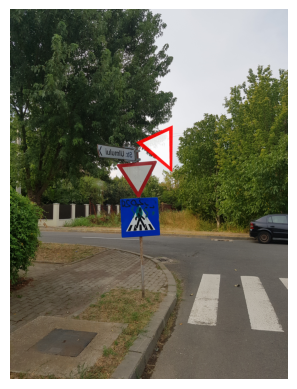

In [173]:
# print a generated give way sign on a immage
def drawRgbSign(p_mat, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
	height_factor = 1

	equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
	if p_height != -1:
		height_factor = p_height / equilateral_height
	else:
		p_height = equilateral_height

	red_tiangle_height = int(equilateral_height * height_factor) 
	converging_factor = 2 / np.sqrt(3) / height_factor # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 1 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
	
	red_band_width = 0.08 * p_side

	for i in range(p_y_start, p_y_start + red_tiangle_height):
		for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
			x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
			y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

			if(np.random.rand() <= px_culling_rate):

				left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
				right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
				bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

				left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
									
				right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

				bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

				if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
					for pixel in range(0, 3):
						p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][pixel] = 255
				else:
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][RED_PX] = 255
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][GREEN_PX] = 0
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][BLUE_PX] = 0

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

drawRgbSign(img, 1372, 1453, 440, 460, -25 * np.pi / 180)

plt.imshow(img)
plt.axis('off')
plt.show()

[31 50 31]


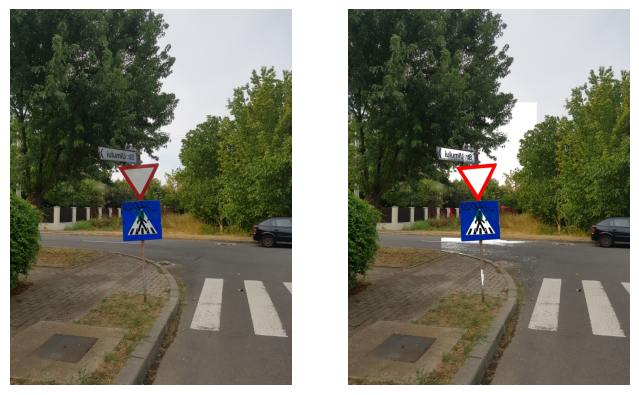

In [174]:
# find treshold values in order to correctly identify white and red

def is_red(p_matrix_px):
    return (int(p_matrix_px[RED_PX]) > 2 * int(p_matrix_px[GREEN_PX]) and int(p_matrix_px[RED_PX]) > 2 * int(p_matrix_px[BLUE_PX]))

def is_white(p_matrix_px):
    pixel_RGB_variance = 20
    minimum_red_brightness = 110

    return  (int(p_matrix_px[RED_PX]) + pixel_RGB_variance > int(p_matrix_px[GREEN_PX]) and\
            int(p_matrix_px[RED_PX]) - pixel_RGB_variance < int(p_matrix_px[GREEN_PX]) and\
            int(p_matrix_px[RED_PX]) + pixel_RGB_variance > int(p_matrix_px[BLUE_PX]) and\
            int(p_matrix_px[RED_PX]) - pixel_RGB_variance < int(p_matrix_px[BLUE_PX]) and\
            p_matrix_px[RED_PX] > minimum_red_brightness)

def check_red(p_img):
    trim = 1000

    for i in range(trim, len(p_img) - trim):
        for j in range(trim, len(p_img[0]) - trim):
            if is_red(p_img[i][j]):
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 0
                p_img[i][j][BLUE_PX] = 0

            if is_white(p_img[i][j]): 
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 255 
                p_img[i][j][BLUE_PX] = 255 

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

check_red(img)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(test_img)

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
plt.show()

In [213]:
# refactored check for sign, that does not print output and uses a method based around points on triangle
def check_for_sign(p_img, p_left_point, p_right_point, p_bottom_point):
	found_triangle_in_line = False
	triangle_area = point_area(p_left_point, p_right_point, p_bottom_point)

	# this optimisation makes everything slower for some reason?
	# pixels_to_show_pc = 1

	# if APPROXIMATE_PIXELS_TO_CHECK < triangle_area:
	# 	pixels_to_show_pc = max(APPROXIMATE_PIXELS_TO_CHECK/triangle_area, 0.01)

	# rect_height = int(view_win_btm_right.y) - int(view_win_top_left.y)  
	# rect_width = int(view_win_btm_right.x) - int(view_win_top_left.x)  
	# culling_rate_i, culling_rate_j = generate_culling_rates(rect_height, rect_width, pixels_to_show_pc)

	color_score = 0
	pixels_checked = 0

	# Calculate the centroid of the original triangle
	centroid_x = (p_left_point.x + p_right_point.x + p_bottom_point.x) / 3
	centroid_y = (p_left_point.y + p_right_point.y + p_bottom_point.y) / 3
	centroid = point(centroid_x, centroid_y)

	# Scale the points towards the centroid
	scaled_left_point = scale_point_towards_centroid(p_left_point, centroid, SMALL_GW_BORDER_PER_CENT)
	scaled_right_point = scale_point_towards_centroid(p_right_point, centroid, SMALL_GW_BORDER_PER_CENT)
	scaled_bottom_point = scale_point_towards_centroid(p_bottom_point, centroid, SMALL_GW_BORDER_PER_CENT)

	view_win_top_left = point(min(p_left_point.x, p_bottom_point.x), min(p_left_point.y, p_right_point.y))
	view_win_btm_right = point(max(p_right_point.x, p_bottom_point.x), p_bottom_point.y)

	culling_rate_i = 1
	culling_rate_j = 1

	# Draw the smaller triangle
	for i in range(int(view_win_top_left.y), int(view_win_btm_right.y), culling_rate_i):
		found_triangle_in_line = False

		for j in range(int(view_win_top_left.x), int(view_win_btm_right.x), culling_rate_j):
			if point_in_triangle(point(j, i), p_left_point, p_right_point, p_bottom_point):
				found_triangle_in_line = True
				pixels_checked += 1

				if point_in_triangle(point(j, i), scaled_left_point, scaled_right_point, scaled_bottom_point):
					if is_white(p_img[i][j]):
						color_score += 1

				else:
					if is_red(p_img[i][j]):
						color_score += 1
			# if found triangle in line and then no longer triangle, to the end of line will not find triangle again 
			elif found_triangle_in_line:
				break
	
	# print("checked", pixels_checked, "of", triangle_area, pixels_checked/triangle_area, "percent")

	return  color_score / pixels_checked



[31 50 31]


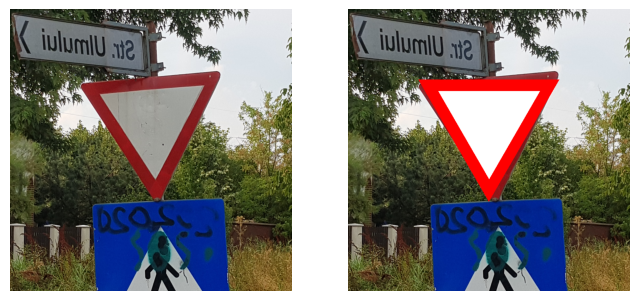

0.8905392507754712


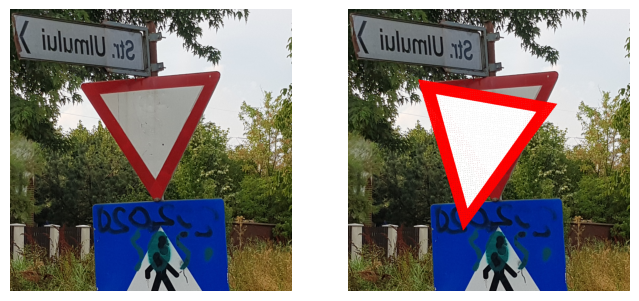

0.4925826446280992


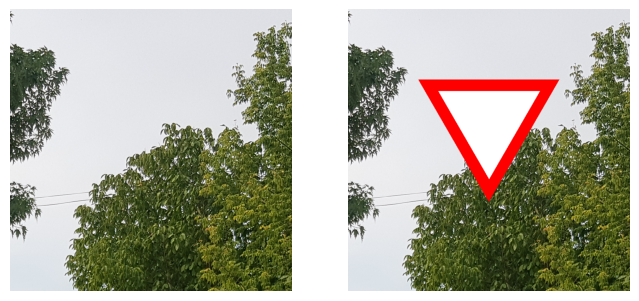

0.4448103078024338


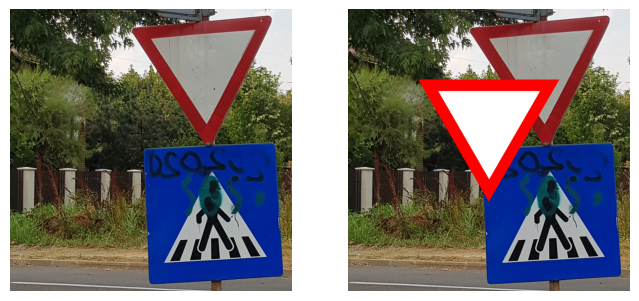

0.049618229539489384


In [176]:
# funciton used to score how close a triangle of side p_side starting at x and y resemples a give way sign

def check_for_sign_with_print(p_img, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
	red_band_width = 0.08 * p_side

	color_score = 0
	p_angle = p_angle * np.pi/180
	height_factor = 1

	equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
	if equilateral_height == 0:
		return
		
	if p_height != -1:
		height_factor = p_height / equilateral_height
	else:
		p_height = equilateral_height

	red_tiangle_height = int(equilateral_height * height_factor) 
	converging_factor = 2 / np.sqrt(3) / height_factor # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 1 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
	

	for i in range(p_y_start, p_y_start + red_tiangle_height):
		for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
			x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
			y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

			if(np.random.rand() <= px_culling_rate):

				left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
				right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
				bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

				left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
									
				right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

				bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

				if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
					
					if is_white(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1
				else:
					if is_red(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1

	plt.figure(figsize=(8, 4))
	plt.subplot(1, 2, 1)
	plt.axis('off')

	border_width = int(p_side / 2)
	plt.imshow(p_img[(p_y_start - border_width):(p_y_start+p_side + border_width), (p_x_start - border_width):(p_x_start+p_side + border_width)])
	
	ideal_sign = p_img[(p_y_start - border_width):(p_y_start+p_side + border_width), (p_x_start - border_width):(p_x_start+p_side + border_width)].copy() 

	drawRgbSign(ideal_sign, border_width, border_width, p_side, red_tiangle_height, p_angle)
	plt.subplot(1, 2, 2)
	plt.axis('off')
	plt.imshow(ideal_sign)

	plt.show()

	return  color_score / pixels_to_check

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

# drawRgbSign(imgu, 0, 1853, 440)
x_val = 1160
y_val = 1680
side = 440

good_score = check_for_sign_with_print(test_img, x_val, y_val, side)
print(good_score)

good_score = check_for_sign_with_print(test_img, x_val, y_val, side, side, 10)
print(good_score)

bad_score = check_for_sign_with_print(test_img, 1853, 1000, 440)
print(bad_score)

bad_score = check_for_sign_with_print(test_img, 1000, 1853, 440)
print(bad_score)




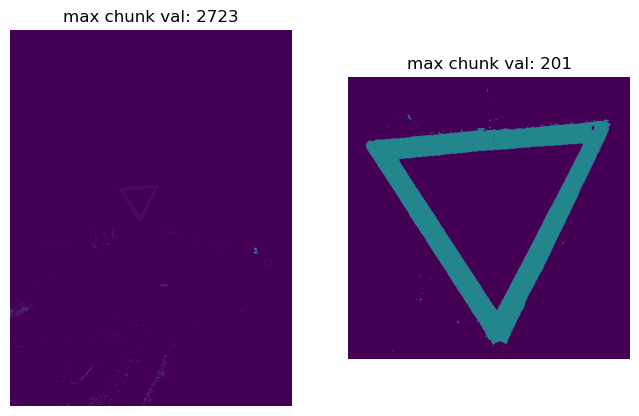

In [236]:
# find red chunks and separate them by labling
from collections import deque

import sys
sys.setrecursionlimit(200000)  # Increase limit as needed

def fill_in_shape_recursive(p_img, p_label_mat, p_label, p_x, p_y):
    if p_x >= len(p_img) - 1 or p_y >= len(p_img[0]) - 1 or p_x <= 1 or p_y <= 1:
        return

    p_label_mat[p_x][p_y] = p_label
    for i in range(-1, 2):
        for j in range(-1, 2):
            if is_red(p_img[p_x + i][p_y + j]) and p_label_mat[p_x + i][p_y + j] == 0:
                fill_in_shape_recursive(p_img, p_label_mat, p_label, p_x + i, p_y + j)

def fill_in_shape(p_img, p_label_mat, p_label, p_x, p_y):
    p_fronteer = deque([]) 

    p_fronteer.append((p_x, p_y))

    current_node = 0

    while len(p_fronteer) > 0:
        curr_x = int(p_fronteer[current_node][0])
        curr_y = int(p_fronteer[current_node][1])

        if not(curr_x >= len(p_img) - 1 or curr_y >= len(p_img[0]) - 1 or curr_x <= 1 or curr_y <= 1):
            p_label_mat[curr_x][curr_y] = p_label
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if is_red(p_img[curr_x + i][curr_y  + j]) and p_label_mat[curr_x + i][curr_y + j] == 0:
                        p_label_mat[curr_x + i][curr_y + j] = p_label

                        p_fronteer.append((curr_x + i, curr_y + j))

        p_fronteer.popleft()


def label_red_chunks(p_img):
    label_mat = np.zeros((len(p_img), len(p_img[0])))
    current_label = 1

    for i in range(1, len(p_img) - 2):
        for j in range(1, len(p_img[0]) - 2):
            if is_red(p_img[i][j]) and label_mat[i][j] == 0:
                fill_in_shape(p_img, label_mat, current_label, i, j)
                current_label += 1
               
               
    return label_mat


labeled_img = label_red_chunks(test_img)
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(labeled_img)
plt.title("max chunk val: " + str(int(np.max(labeled_img))))

plt.subplot(1, 2, 2)
x_val = 1580
y_val = 1130
side = 500 

plt.imshow(labeled_img[x_val:x_val+side, y_val:y_val+side])
plt.title("max chunk val: " + str(int(np.max(labeled_img[x_val:x_val+side, y_val:y_val+side]))))

plt.axis("off")
plt.show()

#7.7 sec with np array
#5.6 sec with dequeue without pop
#5.3 sec with touples instead of double pop and push

In [178]:
# clasify each chunk as large enough to be a sign or not
def get_chunk_coords(p_label_img, label):
    found_chunk = False
    chunk_in_line = False

    found_a_label_pixel = False

    chunk = give_way_chunk(-1, -1, -1)
    # top left and top right will always be the leftest and rightest red points
    chunk.top_left_point = point(x=-1, y=-1)
    chunk.top_right_point = point(x=-1, y=-1)
    # bottom will always be the lowest point
    chunk.bottom_point = point(x=-1, y=-1)

    for i in range(0, len(p_label_img)):
        chunk_in_line = False

        for j in range(0, len(p_label_img[0])):
            if int(p_label_img[i][j]) == label:
                found_chunk = True
                chunk_in_line = True

                if not(found_a_label_pixel):
                    found_a_label_pixel = True

                    chunk.top_left_point.x = j
                    chunk.top_right_point.x = j
                    chunk.bottom_point.x = j

                    chunk.top_left_point.y = i 
                    chunk.top_right_point.y = i
                    chunk.bottom_point.y = i

                else:
                    if(j < chunk.top_left_point.x):
                        chunk.top_left_point.y = i
                        chunk.top_left_point.x = j 

                    if(j > chunk.top_right_point.x):
                        chunk.top_right_point.y = i
                        chunk.top_right_point.x = j

                    if(i > chunk.bottom_point.y):
                        chunk.bottom_point.y = i
                        chunk.bottom_point.x = j
        if found_chunk and not(chunk_in_line):
            return chunk

    return chunk

def get_chunk_sizes(p_label_img):
    chunk_sizes = np.zeros(int(np.max(p_label_img) + 1))
    for i in range(0, len(p_label_img)):
        for j in range(0, len(p_label_img[0])):
            if int(p_label_img[i][j]) > 0:
                chunk_sizes[int(p_label_img[i][j])] += 1

    return chunk_sizes

chunk_sizes = get_chunk_sizes(labeled_img)

min_chunk_size = 1000


chunk 1030
chunk coordonates 2614 2336
checked 407 of 405.0 1.0049382716049382 percent
give way score:  0.48402948402948404


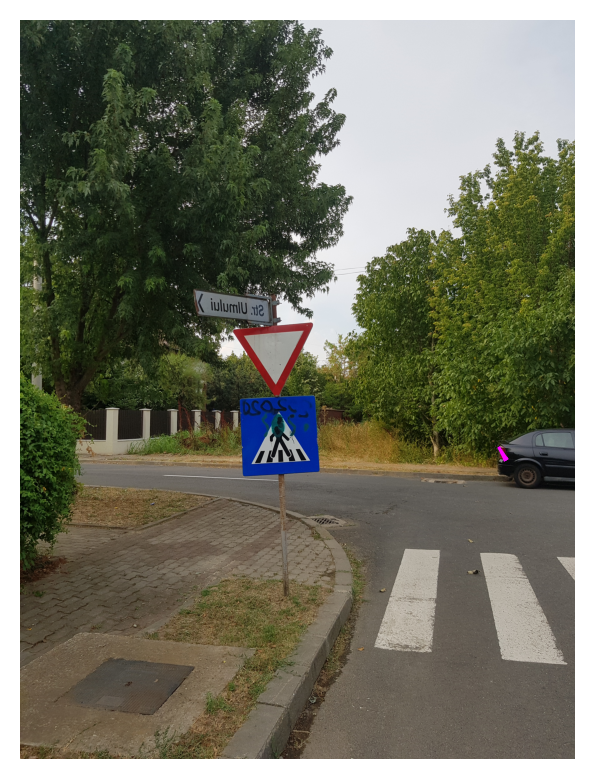

chunk 92 size 41841.0
chunk coordonates 1162 1698
checked 993 of 80505.0 0.01233463760014906 percent
give way score:  0.9033232628398792


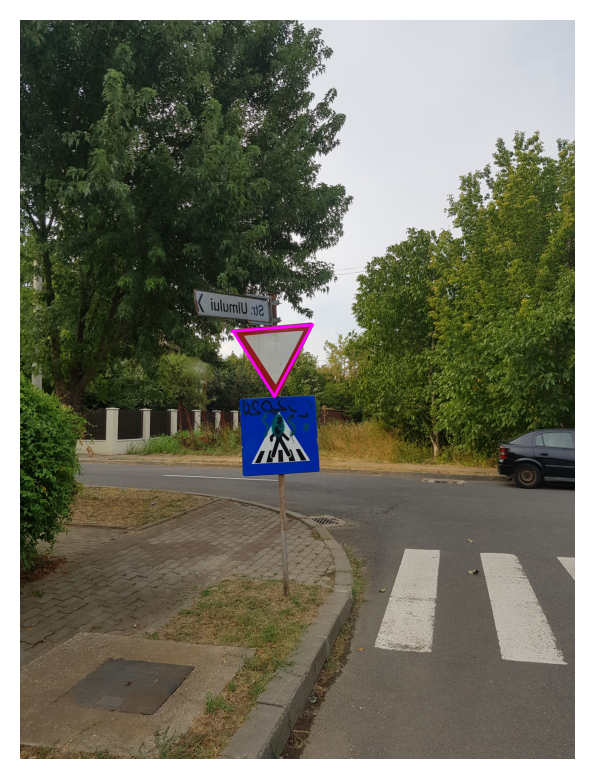

chunk 1030 size 1546.0
chunk coordonates 2614 2336
checked 407 of 405.0 1.0049382716049382 percent
give way score:  0.48402948402948404


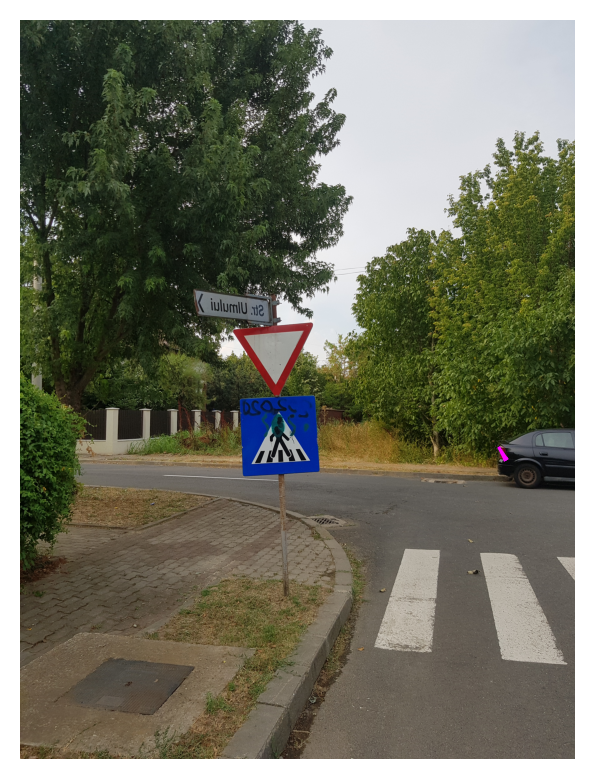

In [208]:
# test previous found data on sign and use it for detection


give_way_chunk_label = 1030 

print("chunk", give_way_chunk_label)

current_chunk = get_chunk_coords(labeled_img, give_way_chunk_label )

img = test_img.copy()

point_to_show = 0
print("chunk coordonates", current_chunk.top_left_point.x, current_chunk.top_left_point.y)

computed_score = check_for_sign(test_img, current_chunk.top_left_point, current_chunk.top_right_point, current_chunk.bottom_point)
print("give way score: ", computed_score)

plt.figure(dpi=200)
plt.imshow(test_img)
plt.axis('off')

plt.plot([current_chunk.top_left_point.x, current_chunk.top_right_point.x], [current_chunk.top_left_point.y, current_chunk.top_right_point.y], color='#FF00FF', linewidth=1)
plt.plot([current_chunk.top_left_point.x, current_chunk.bottom_point.x], [current_chunk.top_left_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1) 
plt.plot([current_chunk.top_right_point.x, current_chunk.bottom_point.x], [current_chunk.top_right_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1)

plt.show()

for i in range(0, len(chunk_sizes)):
    if chunk_sizes[i] > min_chunk_size:
        print("chunk", i, "size", chunk_sizes[i])

        current_chunk = get_chunk_coords(labeled_img, i)

        img = test_img.copy()

        point_to_show = 0
        print("chunk coordonates", current_chunk.top_left_point.x, current_chunk.top_left_point.y)

        computed_score = check_for_sign(test_img, current_chunk.top_left_point, current_chunk.top_right_point, current_chunk.bottom_point)
        print("give way score: ", computed_score)

        plt.figure(dpi=200)
        plt.imshow(test_img)
        plt.axis('off')

        plt.plot([current_chunk.top_left_point.x, current_chunk.top_right_point.x], [current_chunk.top_left_point.y, current_chunk.top_right_point.y], color='#FF00FF', linewidth=1)
        plt.plot([current_chunk.top_left_point.x, current_chunk.bottom_point.x], [current_chunk.top_left_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1) 
        plt.plot([current_chunk.top_right_point.x, current_chunk.bottom_point.x], [current_chunk.top_right_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1)

        plt.show()


        # plt.plot(current_chunk.top_right_point.x, current_chunk.top_right_point.y, 'bo', markersize=2)

        # plt.imshow(img)
        # plt.show()




In [244]:
# this does all the magic
import time

def detect_sign_in_picture(p_img):
    prev_time = time.time()

    min_qualify_score = 0.75

    labeled_img = label_red_chunks(p_img)
    print('labeled red chunks', round(time.time() - prev_time, 2), "sec")
    prev_time = time.time()

    chunk_sizes = get_chunk_sizes(labeled_img)
    print("got chunk sizes", round(time.time() - prev_time, 2), "sec")
    prev_time = time.time()

    min_chunk_size = 1000
    chunks_to_ckeck = []

    for i in range(0, len(chunk_sizes)):
        if chunk_sizes[i] > min_chunk_size:
            chunks_to_ckeck.append(i) 

    for chunk_id in chunks_to_ckeck:
        current_chunk = get_chunk_coords(labeled_img, chunk_id)
        
        computed_score = check_for_sign(p_img, current_chunk.top_left_point, current_chunk.top_right_point, current_chunk.bottom_point)
        
        if computed_score > min_qualify_score:
            print("accuracy: ", computed_score)

            plt.figure(dpi=300)
            plt.imshow(p_img)
            plt.axis('off')

            plt.plot([current_chunk.top_left_point.x, current_chunk.top_right_point.x], [current_chunk.top_left_point.y, current_chunk.top_right_point.y], color='#FF00FF', linewidth=0.3)
            plt.plot([current_chunk.top_left_point.x, current_chunk.bottom_point.x], [current_chunk.top_left_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=0.3) 
            plt.plot([current_chunk.top_right_point.x, current_chunk.bottom_point.x], [current_chunk.top_right_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=0.3)

            plt.savefig(GIVE_WAY_SOLVED_DIR)
            plt.show()
    print("final time:", round(time.time() - prev_time, 2), "sec")

# detect_sign_in_picture(test_img)

# 17.6 sec no optimizations
# 15.1 sec by early return when looking for chunk in get chunk sizes
# 14.5 sec by doing similar optimization to end of row in triangle checking
# 13.7 sec by choosing a faster algorithm for determining if a point is inside a triangle 
# 13.0 sec by only checking 1000 pixels instead of the whole shape
# 10.8 sec with optimised labling

current_img:


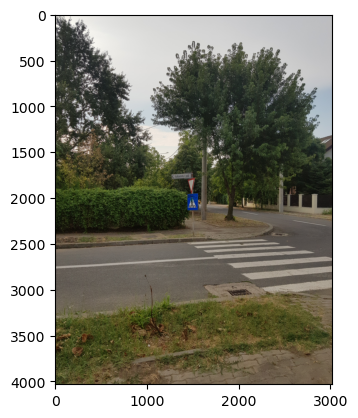

labeled red chunks 4.73 sec
got chunk sizes 2.35 sec
accuracy:  0.7776223776223776
final time: 2.34 sec
current_img:


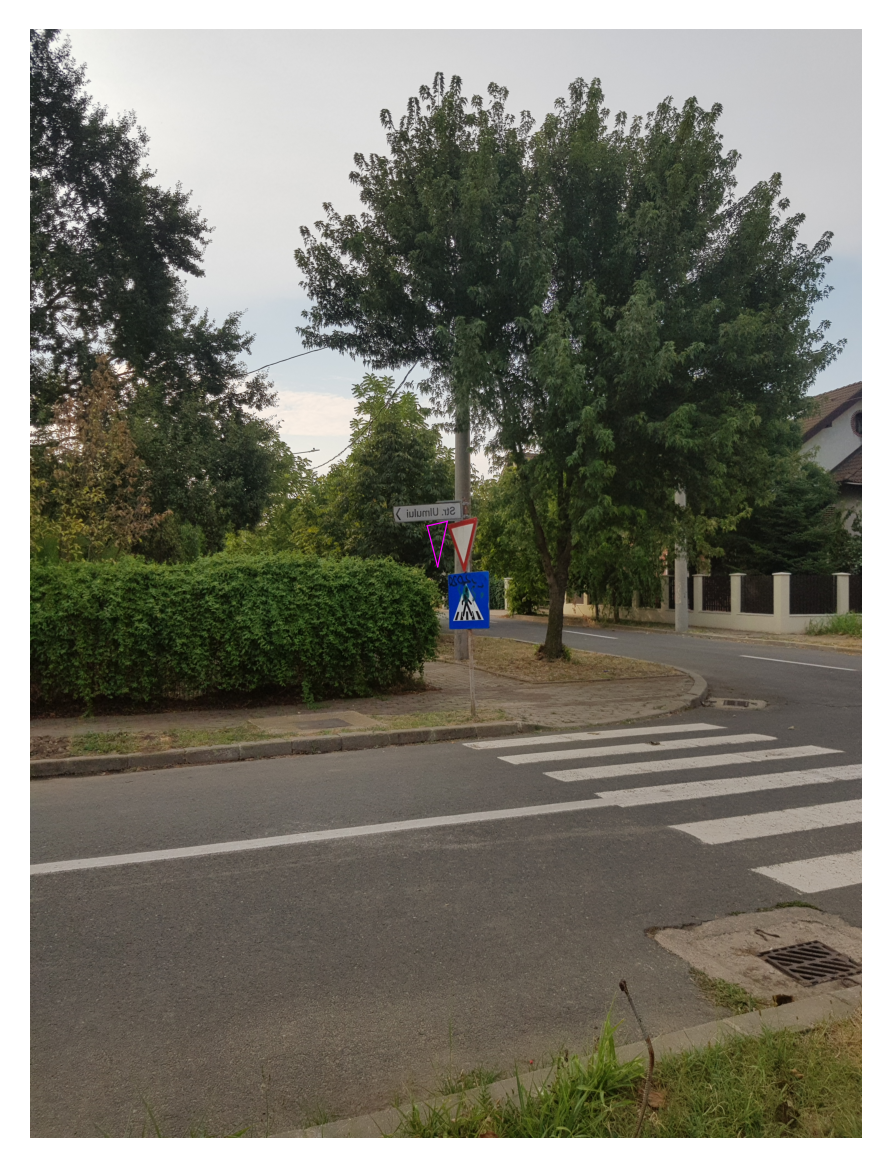

labeled red chunks 4.79 sec
got chunk sizes 2.4 sec
accuracy:  0.8064516129032258
final time: 2.33 sec
current_img:


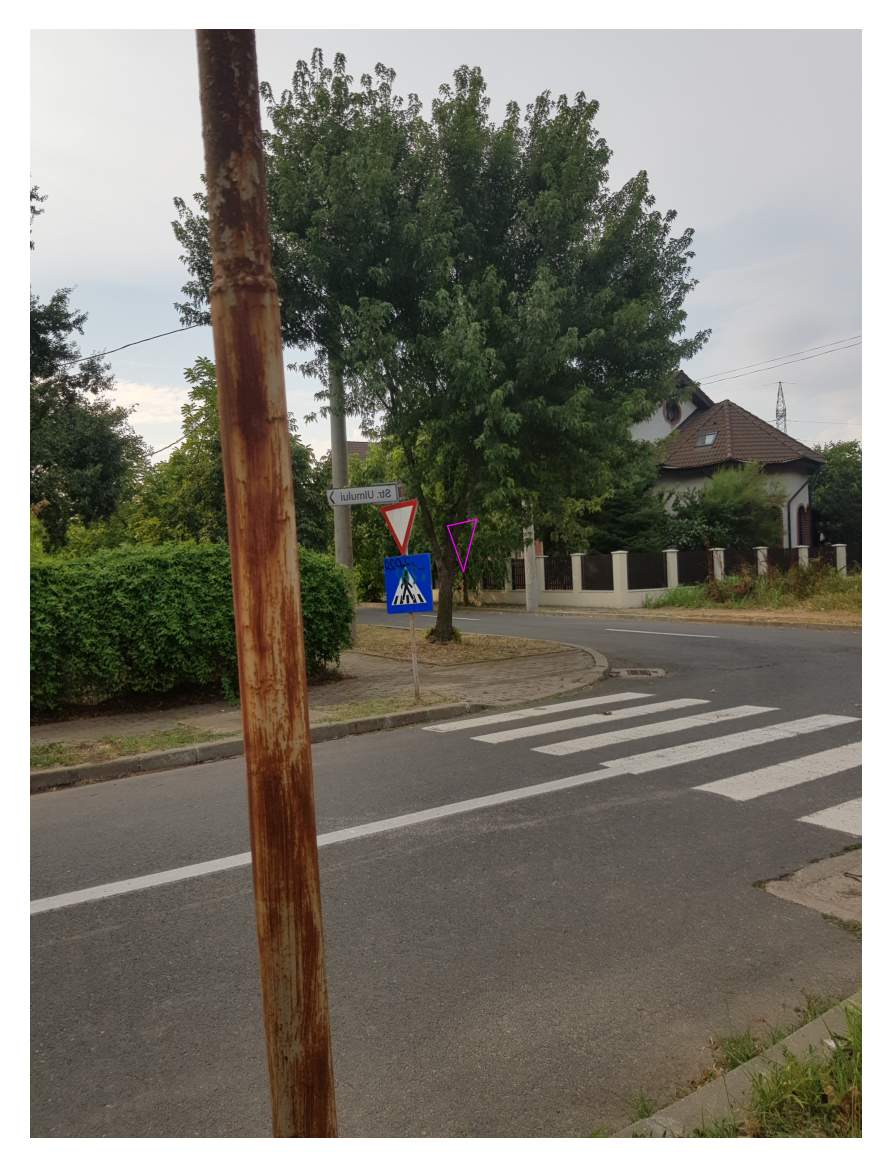

KeyboardInterrupt: 

In [245]:
for img in gw_images:
    print("current_img:")
    plt.imshow(img)
    plt.show()
    detect_sign_in_picture(img)

# 3m 27.3 sec no optimizations
# 2m 44.8 sec by early return when looking for chunk in get chunk sizes
# 2m 40 by doing similar optimization to end of row in triangle checking
# 2m 35.1 sec by choosing a faster algorithm for determining if a point is inside a triangle 
# 2m 45 by checking only a percentage of all pixels in sign?? maybe it's a python thing and will be faster in c++?
# 1m 59 with optimised red chunking function